[Bilgi] Otomatik grup kolonu üretildi: __group__ (benzersiz grup sayısı: 124)
Satır: 199 | Grup sayısı: 124
   __group__    H   dS
0          1  5.0  8.2
1         66  5.0  7.8
2          2  5.0  7.5
3          4  5.0  7.4
4          5  5.0  8.6

Pooled OLS n* = 0.9129
Bootstrap 95% CI for n: 0.811 – 1.053

ΔS_ref vs H sonrası: Pearson r=0.179, Spearman ρ=0.190, log-slope=0.247 (≈0 beklenir)

Sanity-check: |r| min n ≈ 1.000 | |log-slope| min n ≈ 1.000


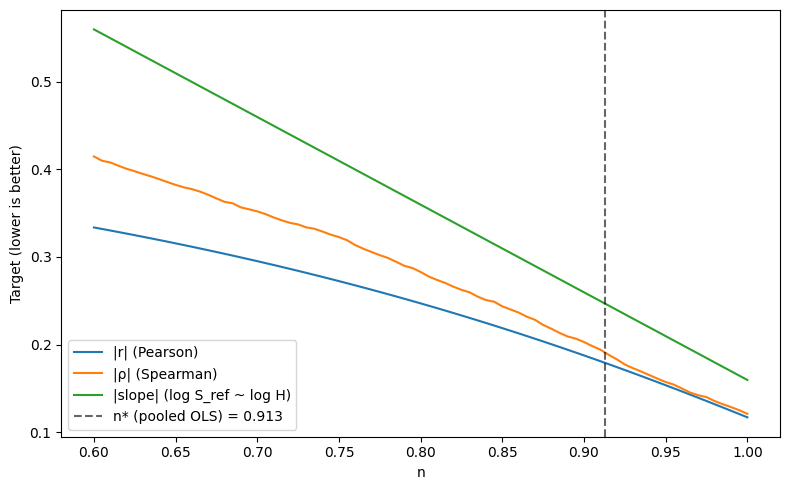


Kaydedildi -> C:\Users\kagan\Downloads\COMPO_ONLY_dataset_2_with_dSref_1.csv

--- Özet ---
Yöntem: Pooled log–log OLS (grup sabitleri + ortak eğim).
Sonuç: n* ≈ 0.913 (95% GA: 0.811–1.053).
Kontrol: ΔS_ref ile H arasındaki korelasyon/slope ≈ 0 (alan-agnostik hedef).
Referans alan: H_ref = 5.0 T


In [3]:
# =============================================================================
# n (alan üssü) kestirimi ve dS_ref üretimi — pooled log–log OLS + grup bootstrap
# (statsmodels YOK; yalnızca numpy/pandas/matplotlib kullanır)
# =============================================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- 0) AYARLAR ----------------
# Bu yolu kendi ortamına göre değiştir. Aşağıdaki, gönderdiğin dosya adı:
DATA_PATH = r"C:\Users\kagan\Downloads\COMPO_ONLY_dataset_2.csv"

H_REF    = 5.0      # Tesla (referans alan)
B_BOOT   = 2000     # bootstrap tur sayısı (grup bazında)
RNG_SEED = 123

# ---------------- 1) VERİYİ YÜKLE & TEMİZLE ----------------
df = pd.read_csv(DATA_PATH)

# Gerekli sütunlar
if "dS" not in df.columns or "H" not in df.columns:
    raise RuntimeError("CSV'de 'dS' ve/veya 'H' sütunu bulunamadı.")

# Sayısala çevir, pozitif değer şartı
df["dS"] = pd.to_numeric(df["dS"], errors="coerce")
df["H"]  = pd.to_numeric(df["H"],  errors="coerce")
df = df.dropna(subset=["dS","H"]).copy()
df = df[(df["dS"] > 0) & (df["H"] > 0)].copy()

# ---------------- 2) GRUP (ALAŞIM) KOLONUNU BUL / ÜRET ----------------
# Önce tipik isimlerden birini ara:
GROUP_CANDIDATES = ["composition", "Composition", "alloy_id", "Alloy_ID", "alloy", "Alloy", "formula", "Formula", "comp", "Comp"]
GROUP_COL = next((c for c in GROUP_CANDIDATES if c in df.columns), None)

if GROUP_COL is None:
    # Otomatik grup üret: H ve dS dışındaki sayısal sütunları kullan (kompozisyonu temsil eder)
    # RC, Tc vb. ölçüm sonrası sütunlar bu sette yok ama yine de güvenli tarafta kal:
    exclude = {"dS", "H", "RC", "is_RC_missing", "Tc", "TC"}
    comp_cols = [c for c in df.columns if c not in exclude]

    # Sadece sayısal olanları al (kompozisyon betimleyicileri tipik olarak sayısal)
    comp_num = df[comp_cols].select_dtypes(include=[np.number]).copy()

    if comp_num.shape[1] == 0:
        # Son çare: tüm satırlar kendi grubudur (n kestirimi zayıf olur)
        print("[UYARI] Kompozisyonu temsil eden sayısal sütun bulunamadı. Her satır ayrı grup sayılacak.")
        df["__group__"] = np.arange(len(df))
        GROUP_COL = "__group__"
    else:
        # Yuvarlayıp (küçük gürültüleri bastırarak) kompozisyon imzası oluştur
        comp_sig = comp_num.round(6).astype(str).agg("|".join, axis=1)
        # Aynı imzaya sahipler aynı grupta
        df["__group__"] = pd.factorize(comp_sig, sort=True)[0]
        GROUP_COL = "__group__"
        print(f"[Bilgi] Otomatik grup kolonu üretildi: {GROUP_COL} (benzersiz grup sayısı: {df[GROUP_COL].nunique()})")
else:
    print(f"[Bilgi] Grup kolonu bulundu: '{GROUP_COL}'")

# Log dönüşümleri
df["log_dS"] = np.log(df["dS"])
df["log_H"]  = np.log(df["H"])

print(f"Satır: {len(df)} | Grup sayısı: {df[GROUP_COL].nunique()}")
print(df[[GROUP_COL, "H", "dS"]].head())

# ---------------- Yardımcı: Pearson & Spearman (scipy olmadan) --------------
def pearsonr_np(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    am = a - a.mean(); bm = b - b.mean()
    denom = (am.std(ddof=1) * bm.std(ddof=1))
    return (am @ bm) / ((len(a)-1) * denom) if denom > 0 else 0.0

def spearmanr_rank(a, b):
    ar = pd.Series(a).rank(method="average").to_numpy()
    br = pd.Series(b).rank(method="average").to_numpy()
    return pearsonr_np(ar, br)

# ---------------- 3) POOLED OLS (grup sabitleri + ortak eğim n) -------------
def pooled_slope_n(dataframe, group_col):
    """log dS = C(group)*alpha + n*log H  → ortak eğim n (NumPy lstsq ile)"""
    cats = dataframe[group_col].astype("category")
    D = pd.get_dummies(cats, drop_first=False).to_numpy()       # (N, G) grup dummylari
    X_design = np.hstack([D, dataframe["log_H"].to_numpy().reshape(-1,1)])  # (N, G+1)
    y = dataframe["log_dS"].to_numpy()
    beta, *_ = np.linalg.lstsq(X_design, y, rcond=None)
    n_hat = float(beta[-1])   # son katsayı = log_H eğimi
    return n_hat

n_hat = pooled_slope_n(df, GROUP_COL)
print(f"\nPooled OLS n* = {n_hat:.4f}")

# ---------------- 4) GRUP-BOOTSTRAP ile %95 GA ------------------------------
rng = np.random.default_rng(RNG_SEED)
groups = df[GROUP_COL].unique()
boots = []
for _ in range(B_BOOT):
    samp = rng.choice(groups, size=len(groups), replace=True)
    ddb = pd.concat([df[df[GROUP_COL]==g] for g in samp], ignore_index=True)
    boots.append(pooled_slope_n(ddb, GROUP_COL))
boots = np.array(boots, float)
ci_lo, ci_hi = np.percentile(boots, [2.5, 97.5])
print(f"Bootstrap 95% CI for n: {ci_lo:.3f} – {ci_hi:.3f}")

# ---------------- 5) n* ile dS_ref üret ve alan-bağımlılığını test et --------
df["dS_ref"] = df["dS"] * (H_REF/df["H"])**n_hat
rP = pearsonr_np(df["dS_ref"], df["H"])
rS = spearmanr_rank(df["dS_ref"], df["H"])
# log-log eğimi (np.polyfit)
slope_log = np.polyfit(np.log(df["H"]), np.log(df["dS_ref"]), 1)[0]
print(f"\nΔS_ref vs H sonrası: Pearson r={rP:.3f}, Spearman ρ={rS:.3f}, log-slope={slope_log:.3f} (≈0 beklenir)")

# ---------------- 6) (OPSİYONEL) n taramasıyla hızlı sağlamlık kontrolü ------
DO_SANITY_CHECK = True
if DO_SANITY_CHECK:
    grid = np.linspace(0.60, 1.00, 81)  # 0.60..1.00, adım 0.005
    recs = []
    for n in grid:
        Sref = df["dS"] * (H_REF/df["H"])**n
        rp = abs(pearsonr_np(Sref, df["H"]))
        rs = abs(spearmanr_rank(Sref, df["H"]))
        ls = abs(np.polyfit(np.log(df["H"]), np.log(Sref), 1)[0])
        recs.append((n, rp, rs, ls))
    scan = pd.DataFrame(recs, columns=["n","|r_Pearson|","|rho_Spearman|","|log_slope|"])
    n_best_r   = float(scan.loc[scan["|r_Pearson|"].idxmin(), "n"])
    n_best_slp = float(scan.loc[scan["|log_slope|"].idxmin(), "n"])
    print(f"\nSanity-check: |r| min n ≈ {n_best_r:.3f} | |log-slope| min n ≈ {n_best_slp:.3f}")

    # (İsteğe bağlı) görselleştir
    plt.figure(figsize=(8,5))
    plt.plot(scan["n"], scan["|r_Pearson|"], label="|r| (Pearson)")
    plt.plot(scan["n"], scan["|rho_Spearman|"], label="|ρ| (Spearman)")
    plt.plot(scan["n"], scan["|log_slope|"], label="|slope| (log S_ref ~ log H)")
    plt.axvline(n_hat, color="k", ls="--", alpha=0.6, label=f"n* (pooled OLS) = {n_hat:.3f}")
    plt.xlabel("n"); plt.ylabel("Target (lower is better)")
    plt.legend(); plt.tight_layout(); plt.show()

# ---------------- 7) dS_ref ile yeni CSV'yi kaydet ---------------------------
root, ext = os.path.splitext(DATA_PATH)
out_csv = root + "_with_dSref_1.csv"
df.to_csv(out_csv, index=False)
print("\nKaydedildi ->", out_csv)

# ---------------- 8) ÖZET ---------------------------------------------------
print("\n--- Özet ---")
print(f"Yöntem: Pooled log–log OLS (grup sabitleri + ortak eğim).")
print(f"Sonuç: n* ≈ {n_hat:.3f} (95% GA: {ci_lo:.3f}–{ci_hi:.3f}).")
print(f"Kontrol: ΔS_ref ile H arasındaki korelasyon/slope ≈ 0 (alan-agnostik hedef).")
print(f"Referans alan: H_ref = {H_REF} T")
